<a href="https://colab.research.google.com/github/dimka11/RuCode_4_regulations/blob/main/rucode_4_catboost_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost # в Colab
# !pip install catboost -U # На Kaggle старая версия catboost

     |████████████████████████████████| 76.3 MB 29 kB/s 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import classification_report, confusion_matrix
from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Подключаем google drive и копируем данные

Использовал colab т.к. на Kaggle закончилась квота gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/regulations-outcome.zip .
!unzip --qq /content/regulations-outcome.zip

### CatBoost with text features

Загрузка и подготовка данных

In [ ]:
# regulations = pd.read_csv('/kaggle/input/regulations-outcome/regulations.csv', index_col=0)
regulations = pd.read_csv('regulations.csv', index_col=0)

In [ ]:
regulations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85006 entries, 5038 to 120262
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   act_title                           85005 non-null  object 
 1   publication_date                    84417 non-null  object 
 2   developer                           84221 non-null  object 
 3   okved_list                          73097 non-null  object 
 4   views_num                           84417 non-null  float64
 5   comments_num                        84417 non-null  float64
 6   likes_num                           84417 non-null  float64
 7   dislikes_num                        84417 non-null  float64
 8   regulatory_impact                   84417 non-null  object 
 9   added_by                            84417 non-null  object 
 10  responsible                         81684 non-null  object 
 11  is_regionally_signigicant           8

In [ ]:
regulations.head()

,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
id,,,,,,,,,,,,,,,,,,,
5038,Об утверждении тарифов на услуги по транспорти...,2013-09-11,ФСТ России,NaN,376.0,0.0,0.0,0.0,Низкая,Митина Ольга Викторовна,Митина Ольга Викторовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5039,О внесении изменений в отдельные законодательн...,2013-06-11,Минтруд России,Здравоохранение; Предоставление социальных услуг,504.0,0.0,0.0,0.0,Низкая,Рахов Виталий Сергеевич,Павлова Зоя Ивановна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5040,Об утверждении Положения об уведомлении лиц об...,2013-04-29,Росфинмониторинг,Финансовая деятельность,428.0,0.0,0.0,0.0,Низкая,Тимофеева Алёна Игоревна,Лях Валерий Владимирович,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5041,О внесении изменений в Положение о Министерств...,2013-10-21,Минобрнауки России,Образование,376.0,0.0,0.0,0.0,Низкая,Вотоновская Ирина Вячеславовна,Михайлова Ирина Вячеславовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5042,О внесении изменений в Правила подготовки и пр...,2014-02-24,Минприроды России,NaN,499.0,0.0,0.0,0.0,Низкая,Соболева Светлана Юрьевна,Соболева Светлана Юрьевна,False,False,Не определено,предоставление водного объекта в пользование п...,Пунктом 12 части 2 статьи 11 Водного кодекса Р...,неопределенный круг лиц,необходимость корреляции Правил подготовки и п...,Проект постановления Правительства Российской ...


In [ ]:
float_vars = ['views_num', 'comments_num', 'likes_num', 'dislikes_num']
cat_vars = ['publication_date', 'developer', 'okved_list', 'regulatory_impact', 'added_by', 'responsible', 'is_regionally_signigicant', 'act_changes_controlling_activities',
            'mineco_solution', 'problem_addressed', 'act_objectives', 'persons_affected_by_act', 'relations_regulated_by_act', 'act_significance']
text_vars = ['act_title']
cat_features = cat_vars

In [ ]:
train_answers = pd.read_csv('train_answer.csv', index_col=0)
# regulations_texts = pd.read_csv('regulations_texts.csv', index_col=0, sep=';')

In [ ]:
train_data = regulations.join(train_answers, how='inner') # Выделяем test часть
train_data = train_data.drop(columns=['passed'])
train_labels = train_answers

test_data = regulations.join(train_answers, how='left')
test_data = test_data[test_data.passed.isnull()]

In [ ]:
# NaNs
train_data.apply(lambda x: x.fillna(value='', inplace=True))
test_data.apply(lambda x: x.fillna(value='', inplace=True))
print('')

In [ ]:
# test train spllit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=41, shuffle=True)

eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data, eval_labels, cat_features, text_vars)
train_dataset = Pool(X_train, y_train, cat_features, text_features=text_vars)

In [ ]:
# class weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train.values)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train.values.reshape(-1))
class_weights = dict(zip(classes, weights))

In [ ]:
#train
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.03,
                           l2_leaf_reg=7,
                           depth=7, eval_metric='AUC',
                           class_weights=class_weights,
                           task_type='GPU',
                           use_best_model=True,
                            tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW'
    ]
                           )


Загрузка модели / обучение

In [ ]:
# load saved model
model.load_model('/content/submission4.cbm', format='cbm')

In [ ]:
# model.fit(train_dataset, eval_set=eval_dataset, verbose=False)

Точность

In [ ]:
from sklearn.metrics import roc_auc_score
test_preds_proba = model.predict_proba(X_test)
roc_auc_score(y_test.values, test_preds_proba[:, 1], average=None)

0.9209176121474809

### Predict

In [ ]:
#predict
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)[:, 1]
# model.save_model('submission4.cbm', format="cbm",) # сохраняем модель

In [ ]:
sample_s = pd.read_csv('sample_submission.csv', index_col=0)
# sample_s['passed'] = preds_proba
test_data_w_pred = test_data
test_data_w_pred.passed = preds_proba
sample_s.passed = test_data_w_pred.passed

sample_s.to_csv('submission4.csv')

Точность 0.87996 / 0.90312 (private / public)

#### Из другим блокнотов:
Пробовал использовать не все фичи - не помогло

In [ ]:
# try with few vars

train_data = train_data[['developer', 'okved_list', 'views_num', 'regulatory_impact', 'added_by', 'responsible', 'is_regionally_signigicant', 'mineco_solution']]
test_data = test_data[['developer', 'okved_list', 'views_num', 'regulatory_impact', 'added_by', 'responsible', 'is_regionally_signigicant', 'mineco_solution']]
cat_features = ['developer', 'okved_list', 'regulatory_impact', 'added_by', 'responsible', 'is_regionally_signigicant', 'mineco_solution']

Пробовал искать гиперпараметры, но public score оказался ниже, чем с наугад подобранными параметрами, хотя на test был лучше

In [ ]:
grid = {'learning_rate': [0.01, 0.02, 0.03, 0.1],
        'depth': [4, 6, 7, 9],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': [1000, 1500, 2000, 2500]}

train_pool = Pool(X_train, y_train, cat_features)
model = CatBoostClassifier(eval_metric='AUC', logging_level='Silent', task_type="GPU")
randomized_search_result = model.randomized_search(grid,
                                                   train_pool,
                                                   verbose=False,
                                                   cv=2,
                                                   plot=False)

randomized_search_result
randomized_search_result["params"]
pickle.dump(randomized_search_result, file = open("randomized_search_result.pickle", "wb"))

Важность признаков

Не нашел способа проинтерпретировать эмбединги текстовой фичи act_title, возможно там можно найти много интересного, хотя и без текстовой фичи скор 0.87572, что совсем чуть ниже

In [ ]:
import copy # в сохраненной модели нет feature_importances_ :(
model1 = copy.deepcopy(model)
model1.fit(train_dataset, eval_set=eval_dataset, verbose=False)

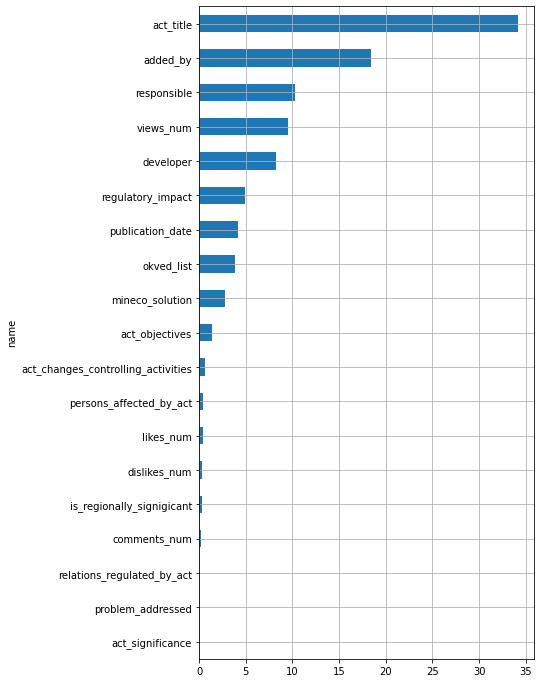

In [ ]:
fi = pd.DataFrame({'name':X_train.columns,'w':model1.feature_importances_})
fi.sort_values('w',inplace=True)

fi.set_index('name')['w'].plot(kind='barh',figsize=(6,12), grid = True)

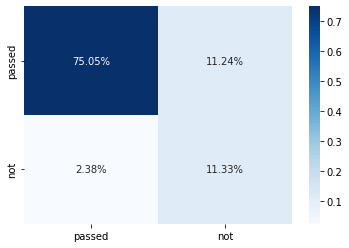

In [ ]:
target_names = ['passed', 'not']
cf_matrix = get_confusion_matrix(model, eval_dataset)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [ ]:
y_pred = model.predict(eval_dataset)

In [ ]:
print('\nClassification Report For Catboost')
print(classification_report(
    eval_labels,
    y_pred, target_names=target_names))


Classification Report For Catboost
              precision    recall  f1-score   support

      passed       0.97      0.87      0.92     13980
         not       0.50      0.83      0.62      2222

    accuracy                           0.86     16202
   macro avg       0.74      0.85      0.77     16202
weighted avg       0.91      0.86      0.88     16202



WordCloud

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
train_data1 = regulations.join(train_answers, how='inner') 

In [ ]:
train_data1['act_title_text'] = train_data1['act_title'].astype(str).apply(lambda x: word_tokenize(x))
train_data1['act_title'].astype(str).apply(lambda x: word_tokenize(x))
print('')

id
5038      [Об, утверждении, тарифов, на, услуги, по, тра...
5039      [О, внесении, изменений, в, отдельные, законод...
5040      [Об, утверждении, Положения, об, уведомлении, ...
5041      [О, внесении, изменений, в, Положение, о, Мини...
5043      [О, внесении, изменений, в, федеральную, целев...
                                ...                        
120256    [Об, использовании, средств, ,, поступающих, в...
120257    [Проект, постановления, Правительства, Российс...
120258    [О, внесении, изменений, в, постановление, Пра...
120260    [Об, утверждении, критериев, отнесения, объект...
120262    [Проект, постановления, Правительства, Российс...
Name: act_title, Length: 81006, dtype: object

In [ ]:
def generate_basic_wordcloud(data):
    cloud = WordCloud(width=600,
                      height=480,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stopwords.words('russian'),
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(15,12))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

In [ ]:
text_passed = ' '.join(train_data1[train_data1['passed'] == 1]['act_title_text'].astype(str).str.lower().tolist())
text_not_passed = ' '.join(train_data1[train_data1['passed'] == 0]['act_title_text'].astype(str).str.lower().tolist())
# wc = WordCloud().generate_from_text(text_passed)

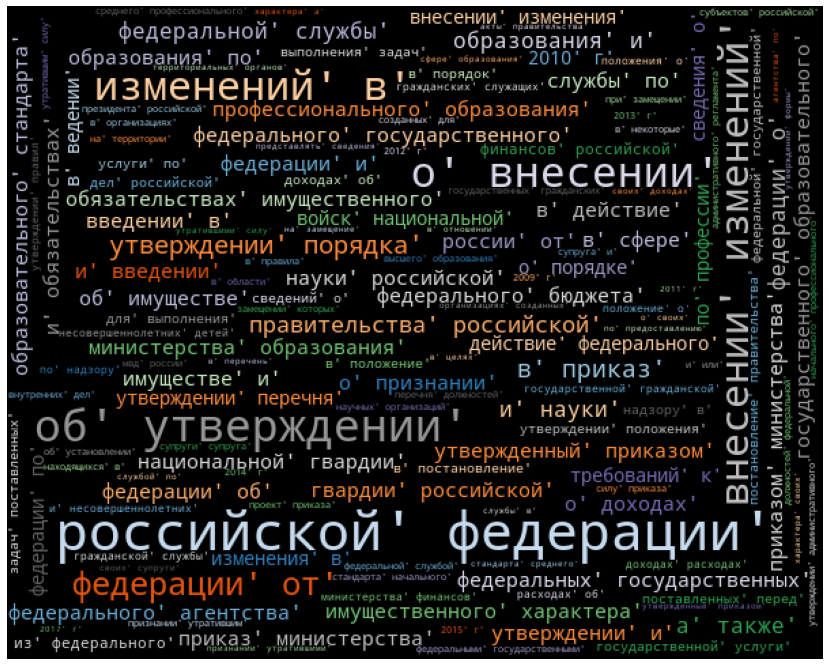

In [ ]:
generate_basic_wordcloud(text_passed)

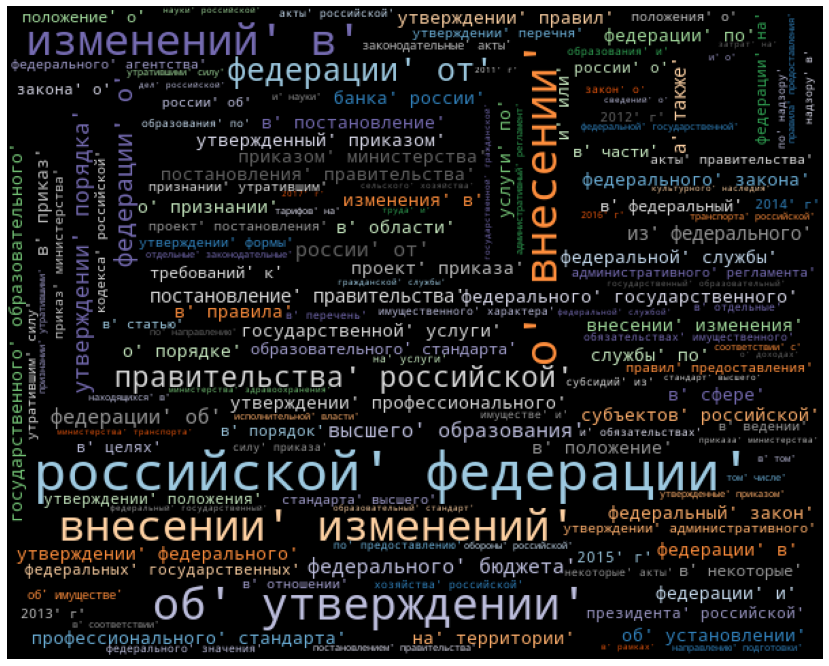

In [ ]:
generate_basic_wordcloud(text_not_passed)